# Monte Carlo -simulointi &ndash; Osakekurssin arvon ennustaminen

Kvantitatiivisten menetelmien strategit käyttävät algoritmeissaan erilaisia työkaluja ja järjestelmiä parantaakseen suorituskykyä ja vähentääkseen riskejä. Yksi tällainen menetelmä on Monte Carlo -simulointi, joka on varsin tehokas optioiden hinnoitteluun tai riskinhallintaan liittyvissä ongelmissa.

Monte Carlo -simulointi edustaa eri lopputulosten todennäköisyyttä prosessissa, jota on haastavaa ennustaa satunnaismuuttujien keskinäisen vaikutuksen vuoksi. Sen ensisijaisena tarkoituksena on saada tietoa riskin ja epävarmuuden vaikutuksista.

Tässä muistiossa näytetään vaiheittain, miten Monte Carlo -simulointi tehdään Pythonilla.



## Monte Carlo -simulointi

Monte Carlo -simulointi on matemaattinen menetelmä, jota käytetään mallintamaan eri lopputulosten todennäköisyyttä prosessissa, jota ei voida muuten helposti ennustaa.

Menetelmän avulla on mahdollista ymmärtää riskin ja epävarmuuden vaikutusta eri aloilla, kuten sijoittamisessa ja kaupankäynnissä. Simuloinnissa rakennetaan malli mahdollisista tuloksista hyödyntämällä todennäköisyysjakaumaa ja lasketaan tulokset yhä uudelleen käyttämällä erilaisia satunnaislukusarjoja ja näin saadaan suuri määrä todennäköisiä tuloksia.

Kyseessä voisi olla esimerkiksi olla tilanne, jossa on kolme muuttujaa, ja sitten Monte Carlo -simulointi ajaa ison määrän simulaatioita, joissa syötteen arvoja vaihdellaan. Näin voidaan paremmin hahmottaa, perustuuko kaupankäyntistrategia tuuriin tai satunnaisuuteen ja onko strategia kestävällä pohjalla. Monte Carlo muuttaa myös tuottojen järjestystä (resampling), mikä jää usein helposti huomiotta.


## Kirjastojen tuonti ja aineiston hakeminen

Ensimmäinen vaihe on tarvittavien Pythonin kirjastojen tuonti. Tässä tapauksessa ne ovat pandas, numpy, matplotlib, finance ja scipy.

Jos kirjastoa _yfinance_ ei ole vielä otettu käyttöön, se pitää tehdä ensin. Google Colabissä sen voi tehdä ajamalla koodisolussa komento
$$\textrm{!pip install --upgrade yfinance}$$

In [1]:
# Tuodaan tarvittavat kirjastot

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm

Kirjaston yfinance avulla voi hakea [Yahoo Finance](https://finance.yahoo.com) -palvelusta historiallisia osakekursseja. Tässä esimerkissä käytetään Koneen osakekursseja Helsingin pörssistä. Muitakin voi tietenkin käyttää vastaavasti. Jokaiseen osakekurssiin liittyy kuuitenkin oma tunnuksensa.

In [2]:
data = yf.download('KNEBV.HE', auto_adjust = False)
data

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,KNEBV.HE,KNEBV.HE,KNEBV.HE,KNEBV.HE,KNEBV.HE,KNEBV.HE
Date,,,,,,
2005-06-01,2.983143,5.663750,5.750000,5.518750,5.518750,5371680
2005-06-02,2.929813,5.562500,5.662500,5.527500,5.627500,4947072
2005-06-03,2.923888,5.551250,5.612500,5.540000,5.600000,1718288
2005-06-06,2.890311,5.487500,5.562500,5.387500,5.555000,5387808
2005-06-07,2.909404,5.523750,5.537500,5.437500,5.475000,7081376
...,...,...,...,...,...,...
2025-03-03,53.848820,55.700001,55.799999,54.220001,54.220001,229896
2025-03-04,53.172085,55.000000,55.700001,54.500000,55.500000,646952


Käytössä on siis Koneen kurssihistoriaan liittyvä aineisto vuoden 2005 kesäkuusta alkaen.

## Logaritmiset tuotot

Seuraavaksi lasketaan logaritmiset päivätuotot. On syytä huomata, että nämä eroavat hieman tavallisista muutosprosenteista. Seuraavassa funktio _pct_change()_ laskee tavallisen muutosprosentin.

In [3]:
log_tuotot = np.log(1+ data['Close'].pct_change())

Liukuma kuvaa jaksollisten päivätuottojen vaihtelua keskiarvosta. Se lasketaan siis kaavalla
$$\textrm{vakiomuutos =  päivätuottojen keskiarvo - (0.5) * varianssi}$$

Lasketaan seuraavaksi tuo liukuma.

In [4]:
ka = log_tuotot.mean()
var = log_tuotot.var()
vakiomuutos = ka - (0.5*var)
vakiomuutos

,0
Ticker,
KNEBV.HE,0.000309


## Luodaan satunnaismuuttujat

Seuraavaksi luodaan satunnaismuuttujat jokaiselle ennustettavalle päivälle ja jokaiselle simuloinnille, joka suoritetaan.

Ensin lasketaan keskihajonta numpy:n funktiolla std().

Nyt on vielä päätettävä, kuinka monta koetta ja päivää halutaan ennustaa. Tässä esimerkissä tehdään 50 päivälle 100 eri koetta.

Tämän jälkeen luodaan matriisi, jonka nimi on M ja jonka muoto on (päivät, toistot) ja joka koostuu standardista normaalijakaumasta saatavista satunnaisluvuista. Tämä tapahtuu kutsumalla ensin np.random.rand(päivät, toistot), joka tuottaa satunnaislukuarvoja väliltä 0 ja 1, ja sen jälkeen käytetään standardin normaalijakauman kumulatiivisen jakaumafunktion käänteisfunktiota (norm.ppf) muuttamaan nämä satunnaisarvot luvuiksi, jotka noudattavat standardia normaalijakaumaa.

Seuraavaksi koodissa otetaan käyttöön uusi muuttuja nimeltä paivatuotot ja kerrotaan jokainen M-matriisin arvo keskihajonnalla ja lisätään siihen liukuma. Kun jokaisesta näin saadusta arvosta $x$ lasketaan arvot $e^x$, saadaan päivittäiset tuotot.

In [5]:
kh = log_tuotot.std()
paivat= 50
toistot = 100
M = norm.ppf(np.random.rand(paivat, toistot))
paivatuotot = np.exp(np.array(vakiomuutos) + np.array(kh)*M)

Sitten muodostetaan päivätuotot-taulukon kanssa samankokoinen taulukko _hintapolut_ ja alustetaan sen arvot nollilla. Hintapolut-taulukon ensimmäinen alkion on tarkasteltavan osakkeen viimeinen päätöskurssi. Tämän jälkeen koodi käy silmukalla läpi toisesta päivästä alkaen aina paivat-muuttujan päiviin asti ja laskee seuraavan päivän hinnan edellisen päivän hinnan ja sitä vastaavan päivittäisen tuoton perusteella.

Kertomalla edellisen päivän hinta päivittäisellä tuotolla simuloidaan kunkin päivän hinnanmuutosta, kun otetaan huomioon päivittäisten tuottojen satunnainen luonne.

In [6]:
hintapolut = np.zeros_like(paivatuotot) # taulukon muoto ja alustus
hintapolut[0] = data['Close'].iloc[-1] # alkuperäisen viimeinen arvo
for t in range(1, paivat):
  hintapolut[t] = hintapolut[t-1] * paivatuotot[t]

## Hintapolkujen piirtäminen

Piirretään vielä tulokset. Siihen käytetään grafiikkakirjastoa matplotlib.

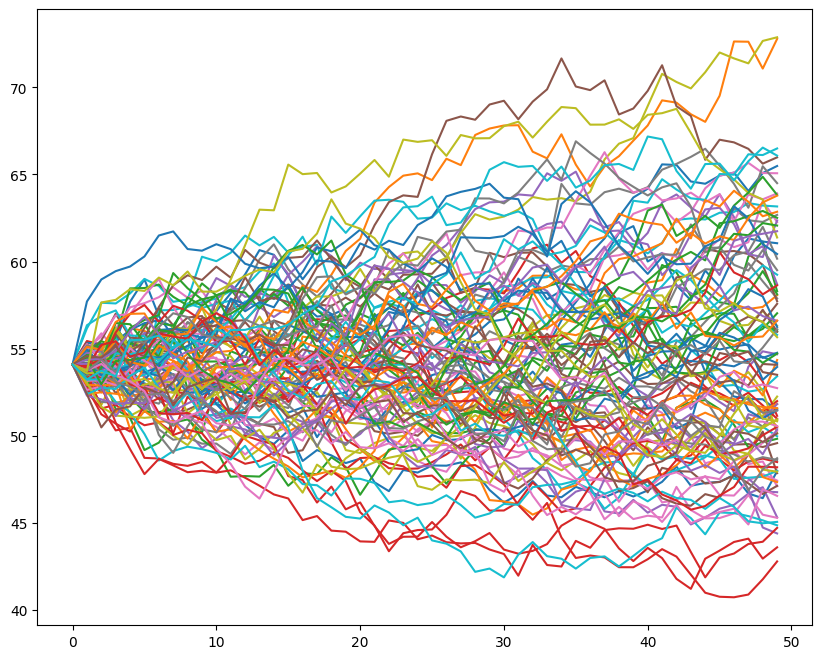

In [7]:
plt.figure(figsize=(10,8))
plt.plot(hintapolut)

In [8]:
print('Minimi: ')
print(hintapolut.min().round(2))

print('Keskiarvo: ')
print(hintapolut.mean().round(2))

print('Keskihajonta: ')
print(hintapolut.std().round(2))

print('Maksimi: ')
print(hintapolut.max().round(2))

Minimi: 
40.74
Keskiarvo: 
54.21
Keskihajonta: 
4.73
Maksimi: 
72.87


Tässä nähdään tarkasteltavan osakekurssin simuloidut osakekurssit seuraaville 50 päivälle perustuen samaan volatiliteettitasoon, joka sillä on historiallisesti ollut. Osake voi sen mukaan päätyä yllä laskettujen minimin ja maksimin välille. Koska jakauma on normaali, osakekurssi voi yhtä hyvin päätyä yllä laskettua keskiarvoa korkeammalle tai alemmalle tasolle.

## Monte Carlo -simuloinnin edut ja haitat

Monte Carlo -menetelmä on arvokas työkalu, jonka avulla voidaan arvioida sijoituksen voitto- tai tappiomahdollisuuksia.

Mikään simulaatio ei kuitenkaan pysty ennustamaan tarkkaa lopputulosta. Monte Carlo -menetelmä pyrkii antamaan luotettavamman arvion siitä, kuinka todennäköisesti tulos poikkeaa ennustetusta arvosta.

Tärkein ero muihin menetelmiin on se, että Monte Carlo -menetelmässä testataan useita satunnaismuuttujia ja lasketaan niiden keskiarvo sen sijaan, että aloitettaisiin keskiarvosta.

Simulointi voi olla arvokas resurssi riskinhallintajärjestelmän täydentämiseksi ja riskien ja tulosten paremmaksi mittaamiseksi.

Alkuperäinen artikkeli: [How To Do A Monte Carlo Simulation Using Python - (Example, Code, Setup, Backtest)](https://www.quantifiedstrategies.com/how-to-do-a-monte-carlo-simulation-using-python/)

In [9]:
import datetime
import pytz

tz = pytz.timezone('Europe/Helsinki')
print(f'Last modified {tz.localize(datetime.datetime.now()):%Y-%m-%d %H:%M} by Juha Nurmonen')

Last modified 2025-03-07 17:33 by Juha Nurmonen
